In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

##### playing with derivaives

In [2]:
def f(x):
    return x**4 - 10*x + 5 

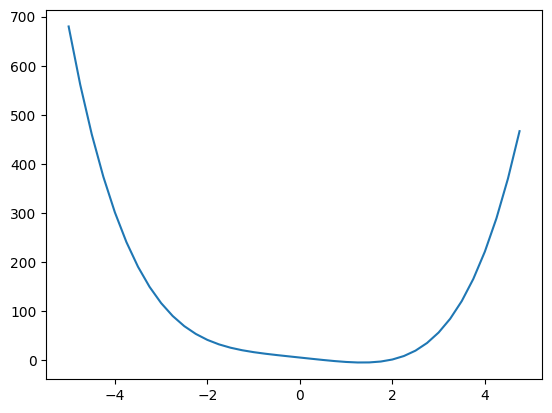

In [3]:
xn = np.arange(-5,5,0.25)
yn = f(xn)
plt.plot(xn,yn)

In [4]:
# derivative is f(x+h)-f(x)/h where h points to zero
# f(x+h) - f(x) tells us about the change and then normalizing it by h gives the slope
h = 0.0000001
x = 2

(f(x+h)-f(x))/h


22.00000238872235

In [5]:
# more complex
a = 8
b = 5
c = 10
d = a*b + c # 50
d1 = a*b + c # 50
h = 0.000001
a += h 
d2 = a*b + c

slope = (d2 - d1) / h
print('d1',d1)
print('d2',d2)
print('slope',slope)



d1 50
d2 50.000004999999994
slope 4.999999994481641


In [32]:
#structuring
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    # what if we add integer into the self.data, lets say int is 1 and there is no 1.data 
         # thats why we have wrote this line of code 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      # we are using += instead of = because if variable is used more than once it will accumulate the grad not just overwrite it
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other):  #other * self (as it will show erorr while doing 1*varname to correct that)
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [7]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [30]:
#from andrej's notebook
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


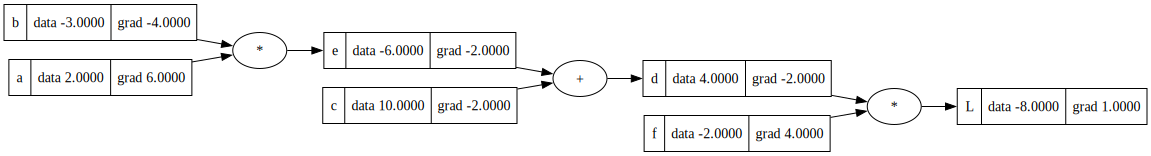

In [9]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0
b.grad = -4.0

draw_dot(L)

example:

dL/dL = 1

dL/df = 4.0

calculation : (f(x+h)-f(x))/h = ((d+h)*f) - (d*f)/h= (d*f + d*h) - (d*f)/h = d

local grad : dd/dc = 1

note: addition is just a distributor of gradient

d = e + c 

f(x+h)-f(x)/h = e + c + h - (e+c )/h = 1

and we know dL/dd  = -2.0 

so global grad: dL/dc =(dL/dd)*(dd/dc) = -2.0

for dL/da: we know dL/de = -2, and we will calculate the local grad which is de/da = b( e = a*b)   - proved above 

do dL/da = (dL/de)*(de/da) = 6.0

In [10]:
# we will nudge the elements in the direction of the gradient and we will expect that the L will increase
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


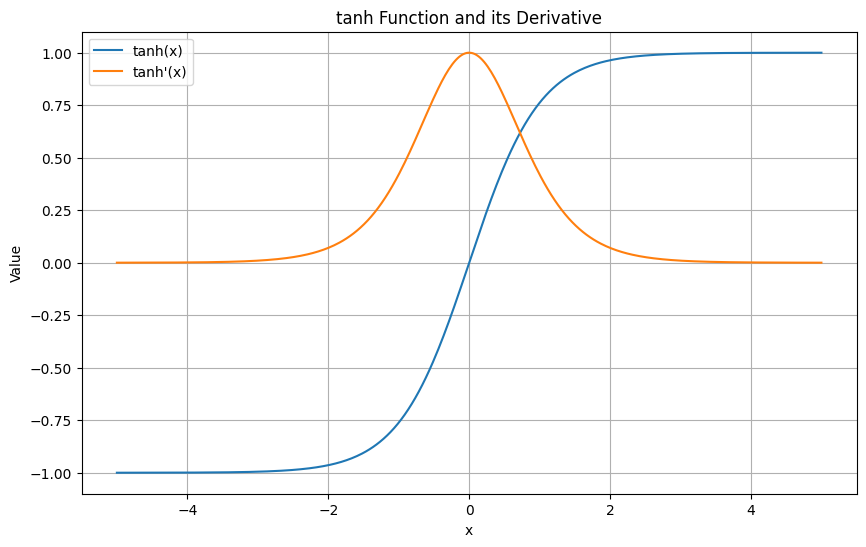

In [11]:
# visualing the tanh activation function 
x = np.linspace(-5, 5, 400)
tanh = np.tanh(x)
tanh_derivative = 1 - np.tanh(x)**2

plt.figure(figsize=(10, 6))
plt.plot(x, tanh, label='tanh(x)')
plt.plot(x, tanh_derivative, label="tanh'(x)")
plt.title('tanh Function and its Derivative')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#### neuron

<img src="https://cs231n.github.io/assets/nn1/neuron_model.jpeg" />



In [12]:
#  neorun 
# in this  case the neorun has two inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
#applying the activation function tanh
o = n.tanh(); o.label = 'o'

In [13]:
#manually backpropogating and setting the grad values
o.grad = 1.0
#o = n.tanh
#do/dn = 1 - o**2 (because the differentiation of the tanh is 1 - tanh^2)
n.grad = 1 - o.data**2 #0.5
#+ is just a distributor of the gradient
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
# the local gradient will be just the varname.data of other element
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

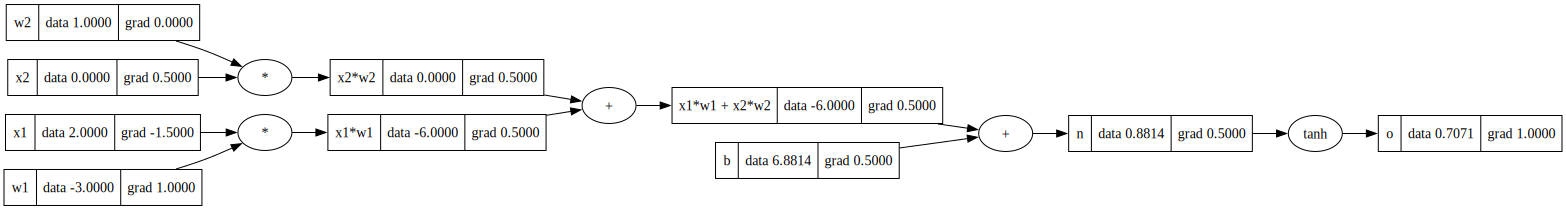

In [14]:
draw_dot(o)

In [15]:

#we will try to make the graph above again with the help of the function which will compute gradient for us
# inputs x1,x2
x_1 = Value(2.0, label='x_1')
x_2 = Value(0.0, label='x_2')
# weights w1,w2
w_1 = Value(-3.0, label='w_1')
w_2 = Value(1.0, label='w_2')
# bias of the neuron
_b = Value(6.8813735870195432, label='_b')
# x1*w1 + x2*w2 + b
x_1w_1 = x_1*w_1; x_1w_1.label = 'x_1*w_1'
x_2w_2 = x_2*w_2; x_2w_2.label = 'x_2*w_2'
x_1w_1x_2w_2 = x_1w_1 + x_2w_2; x_1w_1x_2w_2.label = 'x_1*w_1 + x_2*w_2'
_n = x_1w_1x_2w_2 + _b; _n.label = '_n'
_o = _n.tanh(); _o.label = '_o'

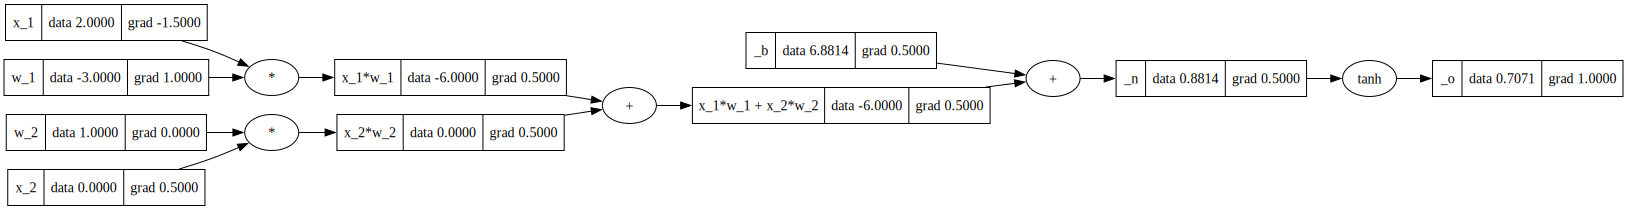

In [24]:
draw_dot(_o)

In [17]:
#now that we have defined the _backward or the process that we did manualy in a function
_o.grad = 1.0
_o._backward()
_n._backward()
x_1w_1x_2w_2._backward()
_b._backward()
x_1w_1._backward()
x_2w_2._backward()
x_1._backward()
w_1._backward()
x_2._backward()
w_2._backward()

In [18]:
# using topological sorting
#Topological sorting is a linear ordering of vertices such that for every directed edge u-v, vertex u comes before v in the ordering
#all the edges go only left to right

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

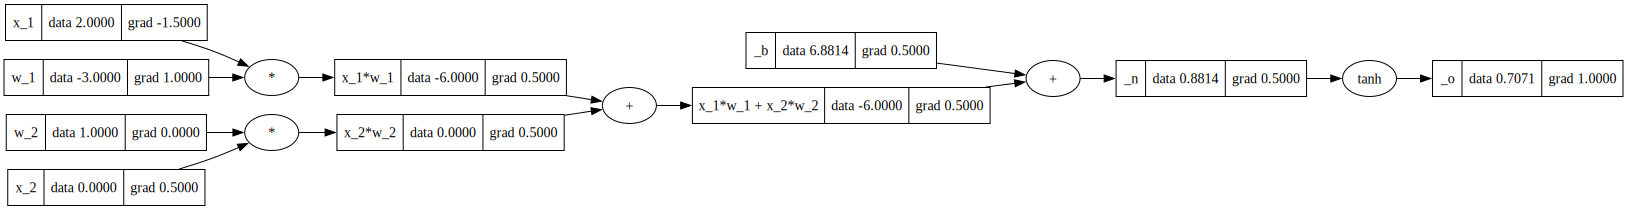

In [19]:
# now that we have implemented the function backward using this topological sorting we will implement it all in once using this
_o.backward()
draw_dot(_o)

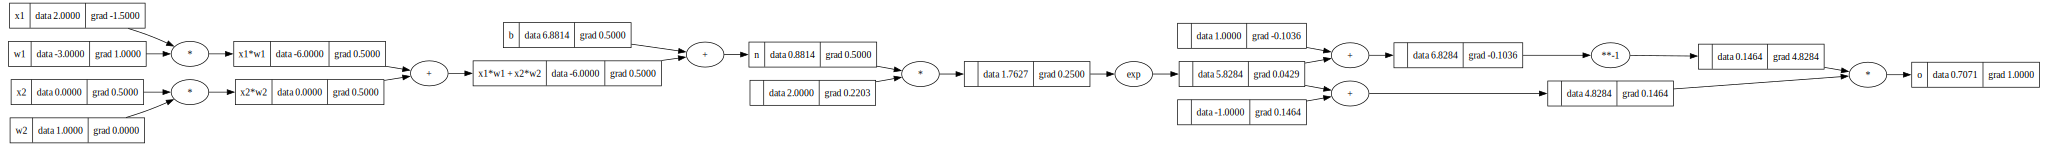

In [33]:
# inputs x1,x2
p1 = Value(2.0, label='x1')
p2 = Value(0.0, label='x2')
# weights w1,w2
k1 = Value(-3.0, label='w1')
k2 = Value(1.0, label='w2')
# bias of the neuron
bias = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
p1k1 = p1*k1; p1k1.label = 'x1*w1'
p2k2 = p2*k2; p2k2.label = 'x2*w2'
p1k1p2k2 = p1k1 + p2k2; p1k1p2k2.label = 'x1*w1 + x2*w2'
f = p1k1p2k2 + bias; f.label = 'n'
# ----
#implementing the tanh activation function from scratch
exp = (2*f).exp()
output = (exp - 1) / (exp + 1)
# ----
output.label = 'o'
output.backward()
draw_dot(output)

In [34]:
# doing the same code but with pytorch
# we are converting the dtype to float64(same as python) using .double()
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

#.item takes the one element and it just returns that one element stripping out the tensor or we can say it just pop outs the element out of the tensor
#like we did in the micrograd torch also has .grad,.tanh etc
print(o.data.item())
o.backward()

#note: in pytorch varname.item() and varname.data.item() gives out the same result 
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


#### building a neural network library in micrograd


In [98]:
import random
class Neuron:
    # here nin is the number of inputs for the neorun
    def __init__(self,nin):
        #w will be a list of the number of the outputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1)) 

    def __call__(self,x):
        #w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    # it will return an array of the parameters
    def parameters(self):
        return self.w + [self.b]
      

class Layer:
  #nout is the no of the neurons in the single layer that we want
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    # this will return simple output when the output layer has one neuron instead of returning a list
    return outs[0] if len(outs) == 1 else outs

  
    '''we can implement the below code in this way also:
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extenf(ps)
    return params'''
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters() ]

class MLP:
  #nouts is the size of the layers that we want
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [99]:
# x is the input layer
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

n(x)

Value(data=-0.7672503948788537)

by the above code block we just built this:

<img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" />

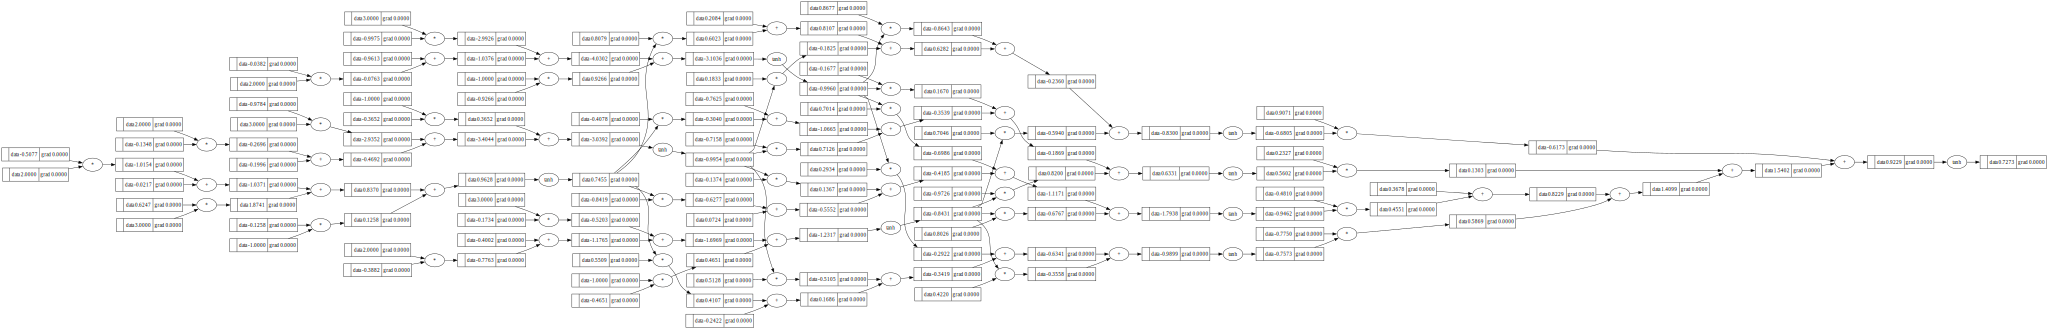

In [72]:
draw_dot(n(x))

In [100]:
# now we will create a tiny dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
#ypred = [n(x) for x in xs]

In [96]:
# calculating the loss
# ygt is the ground truth values
# loss before updating the params
#loss = sum(yout - ygt**2 for ygt, yout in zip(ys,ypred))

In [114]:
#we dont care about the grad of the input layer cause we cant change it
#to display all the parameters -> n.parameters()
# gradient descent - forward pass -> backward pass -> update params


for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

    #backward pass
    # before implementing the backward pass we will firs make the grad = 0.0 otherwise grads will just add up and never reset to 0
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update the params
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k,loss.data)

0 0.020812190039489323
1 0.020686742556657152
2 0.02056271582860337
3 0.02044008635514762
4 0.020318831145989646
5 0.020198927707044727
6 0.020080354027214316
7 0.019963088565575975
8 0.01984711023897679
9 0.019732398410016137
10 0.019618932875403367
11 0.01950669385467702
12 0.01939566197927238
13 0.019285818281924886
14 0.01917714418639802
15 0.019069621497523254
16 0.01896323239154201
17 0.018857959406738317
18 0.018753785434352507
19 0.01865069370976598


In [115]:
#predictions are somewhat matching the targets
ypred

[Value(data=0.9458656260883868),
 Value(data=-0.9671980235766174),
 Value(data=-0.9145448906575229),
 Value(data=0.9143167583424345)]

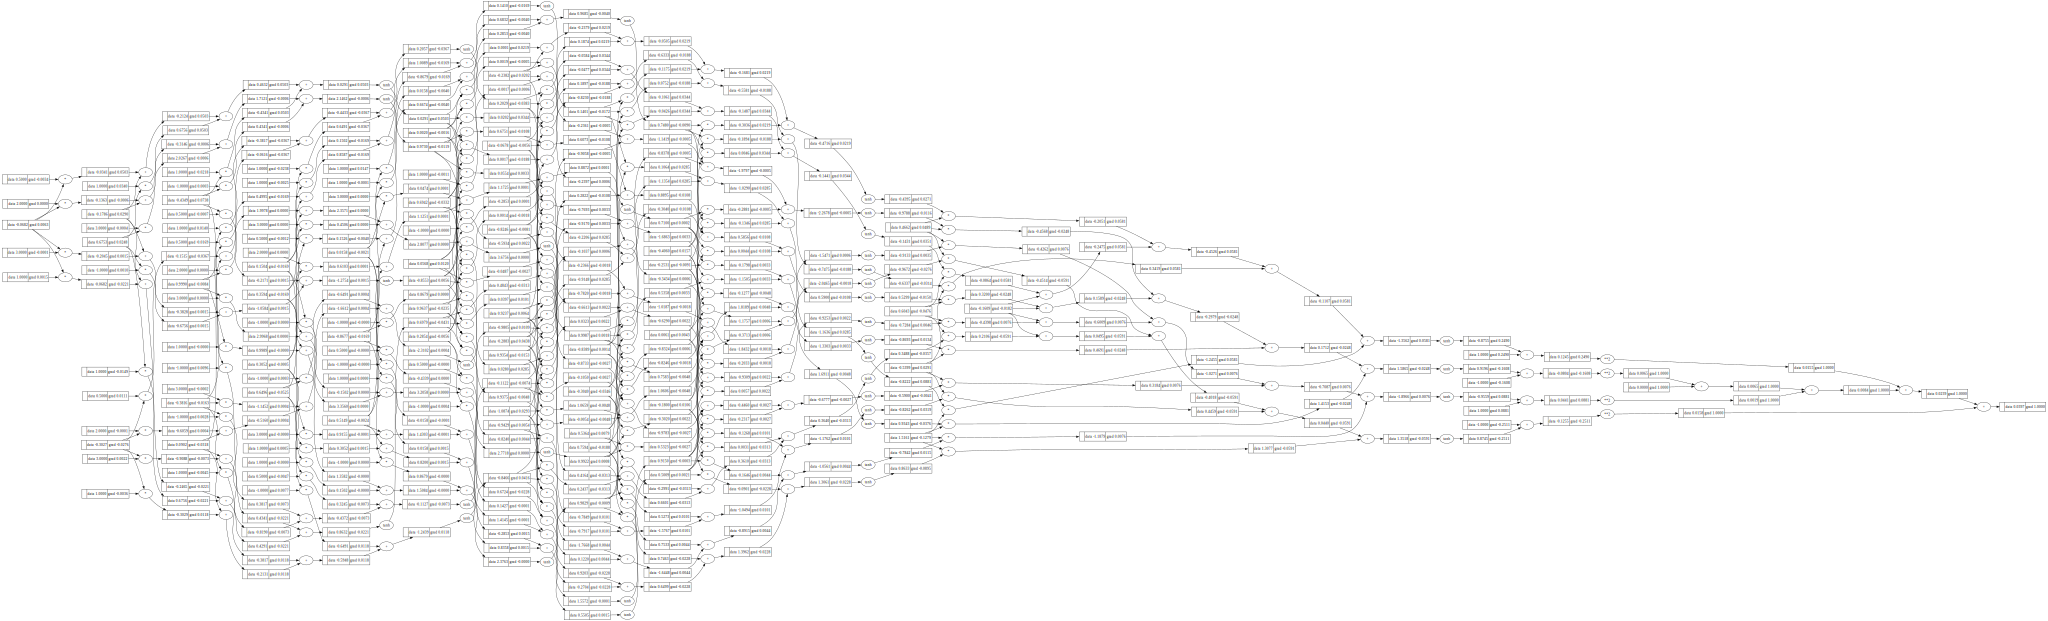

In [108]:
draw_dot(loss)